In [1]:
from osgeo import gdal
from datetime import date, datetime as dt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

## Read Planet Data

In [2]:
planet_fn_red = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/red/planet_red.vrt"
planet_red = gdal.Open(planet_fn_red)
planet_fns = planet_red.GetFileList()[1:]
planet_dates = [dt.strptime((f.split("/"))[-1][0:15], "%Y%m%d_%H%M%S") for f in planet_fns]
p_red = planet_red.ReadAsArray()
p_red[p_red == 0] = np.nan
print p_red.shape

planet_fn_nir = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/nir/planet_nir.vrt"
planet_nir = gdal.Open(planet_fn_nir)
p_nir = planet_nir.ReadAsArray()
p_nir[p_nir == 0] = np.nan
print p_nir.shape

(182, 3424, 3421)
(182, 3424, 3421)


## Read Sentinel Data

In [4]:
sentinel_fn_red = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_red.vrt"
sentinel_red = gdal.Open(sentinel_fn_red)
s_red = sentinel_red.ReadAsArray()
print s_red.shape

sentinel_fns = sentinel_red.GetFileList()[1:]
sentinel_dates = [dt.strptime((f.split("/"))[-1][5:20], "%Y%m%d_%H%M%S") for f in sentinel_fns]

sentinel_fn_nir = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_nir.vrt"
sentinel_nir = gdal.Open(sentinel_fn_nir)
s_nir = sentinel_nir.ReadAsArray()
print s_nir.shape

# Get lat/lon information
transf = sentinel_red.GetGeoTransform()
reslon = transf[1]
reslat = transf[5]
cols = sentinel_red.RasterXSize
rows = sentinel_red.RasterYSize
LHS = transf[0]
THS = transf[3]
BHS = THS + (rows * reslat)
RHS = LHS + (cols * reslon)

latgrid = np.arange(THS, BHS, reslat)
longrid = np.arange(LHS, RHS, reslon)

(12, 3424, 3421)
(12, 3424, 3421)


## Extract Values from NDVI stack

In [5]:
tl_pixel_lat = 4062320
tl_pixel_lon = 235443

br_pixel_lat = 4061520
br_pixel_lon = 236117

# ===== GET ROW/COLS FOR PIXEL LAT/LON ===== #

tl_pix_x = abs(longrid - tl_pixel_lon).argmin()
tl_pix_y = abs(latgrid - tl_pixel_lat).argmin()
br_pix_x = abs(longrid - br_pixel_lon).argmin()
br_pix_y = abs(latgrid - br_pixel_lat).argmin()

# ===== EXTRACT SENTINEL VALUES ===== #

sentinel_r = []
sentinel_n = []
sentinel_n_std = []
sentinel_r_std = []

for i in range(0, (s_red.shape)[0]):
        
    sentinel_r.append(np.nanmean(s_red[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    sentinel_n.append(np.nanmean(s_nir[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    sentinel_r_std.append(np.nanstd(s_red[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    sentinel_n_std.append(np.nanstd(s_nir[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    
sentinel_df = pd.DataFrame(index = sentinel_dates)
sentinel_df['red'] = sentinel_r
sentinel_df['nir'] = sentinel_n
sentinel_df['red_std'] = sentinel_r_std
sentinel_df['nir_std'] = sentinel_n_std

# ===== EXTRACT PLANET VALUES ===== #

planet_r = []
planet_n = []
planet_n_std = []
planet_r_std = []

for i in range(0, (p_nir.shape)[0]):
        
    planet_r.append(np.nanmean(p_red[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    planet_n.append(np.nanmean(p_nir[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    planet_r_std.append(np.nanstd(p_red[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))
    planet_n_std.append(np.nanstd(p_nir[i, tl_pix_y:br_pix_y, tl_pix_x:br_pix_x]))

planet_df = pd.DataFrame(index = planet_dates)
planet_df['red'] = planet_r
planet_df['nir'] = planet_n
planet_df['red_std'] = planet_r_std
planet_df['nir_std'] = planet_n_std

# Get rid of NaN values present in a row
#planet_df = planet_df[np.isfinite(planet_df['ndvi'])]
planet_df = planet_df.drop(planet_df[(planet_df.red < 0.1)].index)

print "Done."


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Done.


## Extract Values from MODIS csv file

In [6]:
# ===== MCD43 OPENING... ===== #

MCD43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/bdrf-235799-4061930/BDRF-235799-4061930-MCD43A1-006-results.csv", index_col=2)

MCD43_df = pd.DataFrame(index = MCD43.index)
MCD43_df['nir'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
MCD43_df['red'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
MCD43 = None

# MCD43_df = MCD43_df[MCD43_df.nir < 0.4]


In [7]:
# ===== MCD43 OPENING... ===== #

mcd43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/bdrf-235799-4061930/BDRF-235799-4061930-MCD43A1-006-results.csv", index_col=2)

mcd43_df = pd.DataFrame(index = mcd43.index)
mcd43_df['nir_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
mcd43_df['nir_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_1']
mcd43_df['nir_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_2']

mcd43_df['red_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
mcd43_df['red_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_1']
mcd43_df['red_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_2']


In [8]:
import xmltodict
import sys
import glob

sys.path.append('/home/tday/BEIS-LC/MODIS')

from Kernels import Kernels

def correction(fiso, fvol, fgeo, giso, gvol, ggeo):
    
    result = (fiso * giso) + (fvol * gvol) + (fgeo * ggeo)
    return result

# ===== Extract illumin conditions from planet xml ===== #

check_date = date(2017, 3, 1)

xmlfiles = sorted(glob.glob("/data/001_planet_sentinel_study/planet/utm11n_sur_ref/xml/*.xml"))

xdates = []
VAA = []
VZA = []
SZA = []
SAA = []
RO = []
LI = []

for xml in xmlfiles:
    
    xmldate = dt.strptime((xml.split("/"))[-1][0:8], "%Y%m%d").date()

    if xmldate == check_date:
        pass
        
    else: 
        xdates.append(xmldate)
        
        with open(xml) as fd:
        
            doc = xmltodict.parse(fd.read())
            acq = doc['ps:EarthObservation']['gml:using']['eop:EarthObservationEquipment']['eop:acquisitionParameters']['ps:Acquisition']

            sazimuth = float(acq['opt:illuminationAzimuthAngle']['#text'])
            SAA.append(sazimuth)

            szenith = float(acq['opt:illuminationElevationAngle']['#text'])
            SZA.append(szenith)

            vazimuth = float(acq['ps:azimuthAngle']['#text'])
            VAA.append(vazimuth)

            vzenith = float(acq['ps:spaceCraftViewAngle']['#text'])
            VZA.append(vzenith)

            check_date = xmldate

            RAA = sazimuth - vazimuth

            kk = Kernels(vzenith, szenith, RAA, \
                 RossHS = False, RecipFlag = True, MODISSPARSE = True, \
                 normalise = 1, doIntegrals = False, LiType = 'Sparse', RossType = 'Thick' )

            RO.append(kk.Ross[0])
            LI.append(kk.Li[0])

bdrf_df = pd.DataFrame(index = xdates)  
bdrf_df['ROSS'] = RO
bdrf_df['LI'] = LI

CORR = pd.merge(bdrf_df, mcd43_df, left_index=True, right_index=True)

CORR['FINAL_nir'] = correction(CORR['nir_iso'], CORR['nir_vol'], CORR['nir_geo'], 1, CORR['ROSS'], CORR['LI']) * 10000
CORR['FINAL_red'] = correction(CORR['red_iso'], CORR['red_vol'], CORR['red_geo'], 1, CORR['ROSS'], CORR['LI']) * 10000


# Plot

<IPython.core.display.Javascript object>


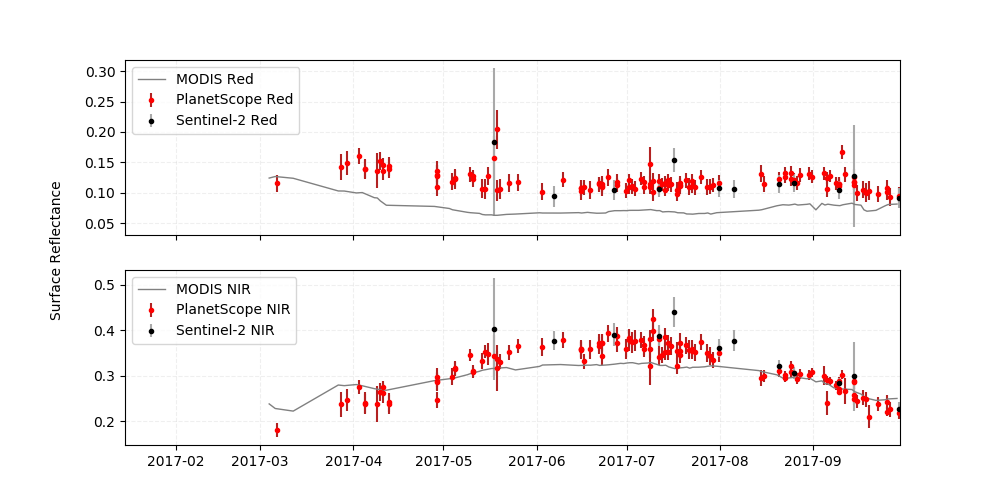

In [16]:
fig, ax = plt.subplots(figsize=(10,5), sharex=True)

ax = plt.subplot(2,1,1)

ax.errorbar(planet_df.index, planet_df['red']/10000, 
             yerr=planet_df['red_std']/10000, fmt='o', ecolor='firebrick', capthick=0.5, ms=3,
             label='PlanetScope Red', color='red')

ax.errorbar(sentinel_df.index, sentinel_df['red']/10000, 
             yerr=sentinel_df['red_std']/10000, fmt='o', ecolor='darkgray', capthick=0.5, ms=3,
             label='Sentinel-2 Red', color='black')

ax.plot_date(CORR.index, CORR['FINAL_red']/10000, '-', color='gray', linewidth=1, label="MODIS Red")

ax.legend(loc = 'upper left')
ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])

labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.grid(ls = '--', alpha=.2)

ax = plt.subplot(2,1,2)

ax.errorbar(planet_df.index, planet_df['nir']/10000, 
             yerr=planet_df['nir_std']/10000, fmt='o', ecolor='firebrick', capthick=0.5, ms=3,
             label='PlanetScope NIR', color='red')

ax.errorbar(sentinel_df.index, sentinel_df['nir']/10000, 
             yerr=sentinel_df['nir_std']/10000, fmt='o', ecolor='darkgray', capthick=0.5, ms=3,
             label='Sentinel-2 NIR', color='black')

ax.plot_date(CORR.index, CORR['FINAL_nir']/10000, '-', color='gray', linewidth=1, label="MODIS NIR")

ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])
ax.legend(loc = 'upper left')
plt.grid(ls = '--', alpha=.2)

fig.text(0.05, 0.5, 'Surface Reflectance', va='center', rotation='vertical')


plt.show()

<IPython.core.display.Javascript object>


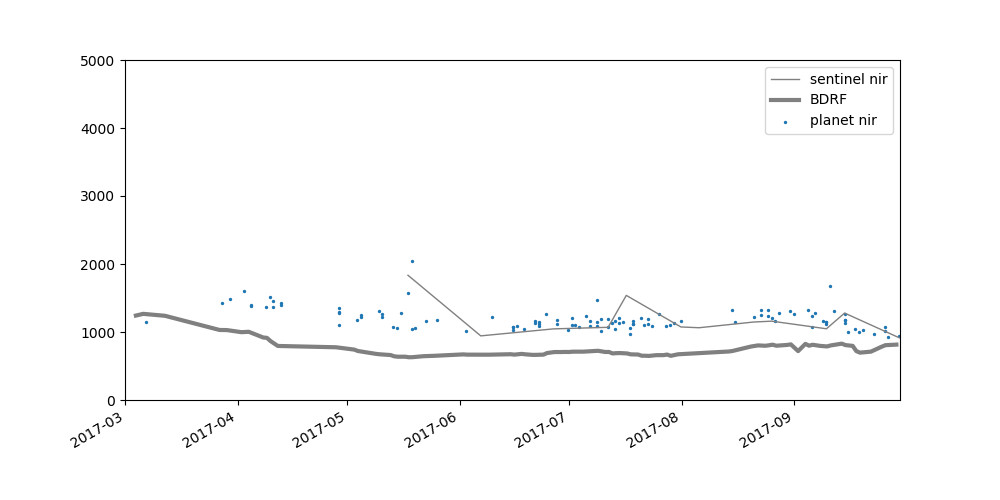

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

# ax.plot_date(planet_df.index, planet_df['red'], '-', color='red', linewidth=1, label="planet red")

plt.scatter(planet_df.index, planet_df['red'], label="planet nir", s=2)

# ax.plot_date(MCD43_df.index, MCD43_df['red'], '-', color='Black', linewidth=2)

# ax.plot_date(MCD43_df.index, MCD43_df['nir'], '-', color='Black', linewidth=2)

# ax.plot_date(sentinel_df.index, sentinel_df['red'], '-', color='red', linewidth=3, label="sentinel red")

ax.plot_date(sentinel_df.index, sentinel_df['red'], '-', color='gray', linewidth=1, label="sentinel nir")

# ax.plot_date(CORR.index, CORR['FINAL_red'], '-', color='red', linewidth=5, label='BDRF')

ax.plot_date(CORR.index, CORR['FINAL_red'], '-', color='gray', linewidth=3, label="BDRF")
# ax.plot_date(CORR.index, CORR['nir_iso']*10000, '-', color='gray', linewidth=5, label="BDRF")

fig.autofmt_xdate()
ax.set_xlim([date(2017, 3, 1), date(2017, 9, 30)])
ax.set_ylim([0, 5000])

plt.legend()
plt.show()

In [ ]:
plt.imshow(p_red[11,:,:], extent=[LHS, RHS, BHS, THS])
#plt.scatter(pixel_lon, pixel_lat, color='pink')
plt.show()

In [ ]:
# # ===== MOD09 OPENING... ===== #

# MOD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MOD09/MOD09-MOD09GQ-006-results.csv", index_col=2)

# MOD09_df = pd.DataFrame(index = MOD09.index)
# MOD09_df['nir'] = MOD09['MOD09GQ_006_sur_refl_b02_1']
# MOD09_df['red'] = MOD09['MOD09GQ_006_sur_refl_b01_1']
# MOD09 = None

# MOD09_df = MOD09_df[MOD09_df.nir < 0.4]

# MOD09_df['ndvi'] = ((MOD09_df.nir-MOD09_df.red)/(MOD09_df.nir+MOD09_df.red))

# # ===== MYD09 OPENING... ===== #

# MYD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MYD09/MYD09-MYD09GQ-006-results.csv", index_col=2)

# MYD09_df = pd.DataFrame(index = MYD09.index)
# MYD09_df['nir'] = MYD09['MYD09GQ_006_sur_refl_b02_1']
# MYD09_df['red'] = MYD09['MYD09GQ_006_sur_refl_b01_1']
# MYD09 = None

# MYD09_df = MYD09_df[MYD09_df.nir < 0.4]

# MYD09_df['ndvi'] = ((MYD09_df.nir-MYD09_df.red)/(MYD09_df.nir+MYD09_df.red))
